In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
from keras import regularizers
from keras.layers import LeakyReLU

In [47]:
df = pd.read_csv('mag7.csv', index_col="Date", parse_dates=True)

In [48]:
df.head()

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2014-11-24,29.657499,16.782000,27.374001,74.010002,47.590000,0.51450,16.448000
2014-11-25,29.400000,16.752001,27.461500,75.629997,47.470001,0.51425,16.539333
2014-11-26,29.750000,16.678499,27.386499,77.620003,47.750000,0.52300,16.562668
2014-11-28,29.732500,16.931999,27.454000,77.699997,47.810001,0.52425,16.301332
2014-12-01,28.767500,16.299999,26.982500,75.099998,48.619999,0.51450,15.442667


In [49]:
df.describe()

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
count,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000
mean,94.057333,99.079404,81.062714,216.702748,183.595726,19.355752,111.591938
std,63.735143,53.441023,42.836502,116.049932,120.972201,29.999172,110.706607
min,22.584999,14.347500,24.853001,74.010002,40.290001,0.478500,9.578000
25%,36.456251,47.692999,46.849501,133.445000,69.080002,3.332500,16.967999
50%,63.702499,93.835503,62.955502,181.440002,146.919998,6.321500,24.749332
75%,150.815002,152.216499,117.897251,275.569992,279.629990,20.349500,217.726669
max,236.479996,214.100006,191.179993,595.940002,467.559998,148.880005,409.970001


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2014-11-24 to 2024-11-20
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2515 non-null   float64
 1   AMZN    2515 non-null   float64
 2   GOOGL   2515 non-null   float64
 3   META    2515 non-null   float64
 4   MSFT    2515 non-null   float64
 5   NVDA    2515 non-null   float64
 6   TSLA    2515 non-null   float64
dtypes: float64(7)
memory usage: 157.2 KB


In [51]:
def plot_stock_prices(df):
  # Plot each stock's time series
  plt.figure(figsize=(12, 8))
  for column in df.columns:
      plt.plot(df.index, df[column], label=column)

  plt.xlabel("Date")
  plt.ylabel("Closing Price")
  plt.title("Magnificent 7 Stock Prices")
  plt.legend()
  plt.grid(True)
  plt.show()

  return

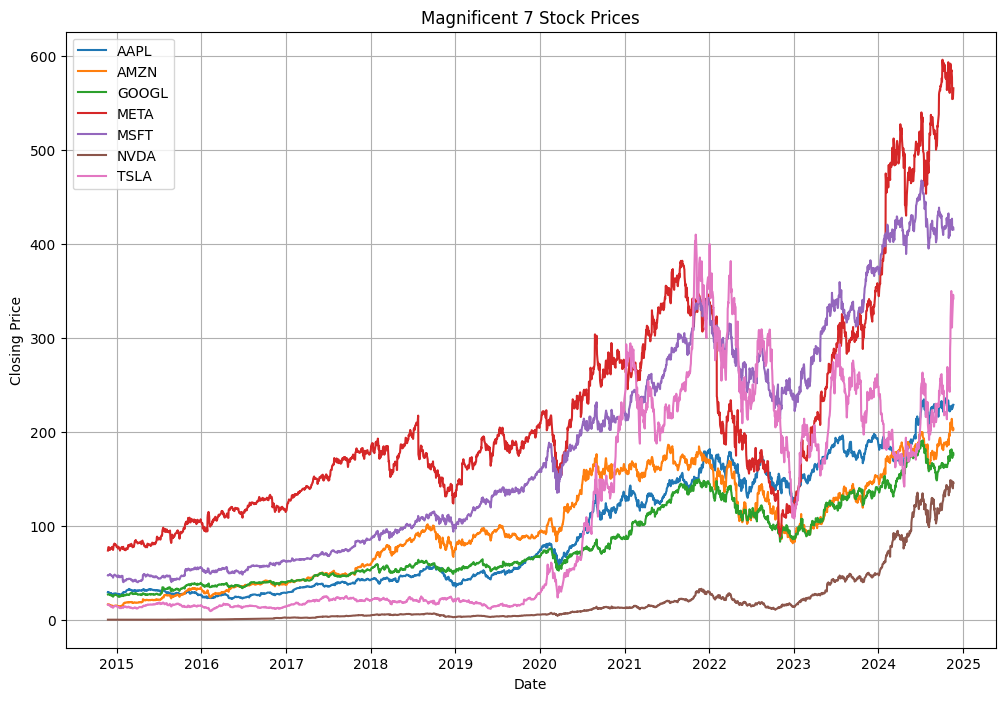

In [52]:
plot_stock_prices(df)

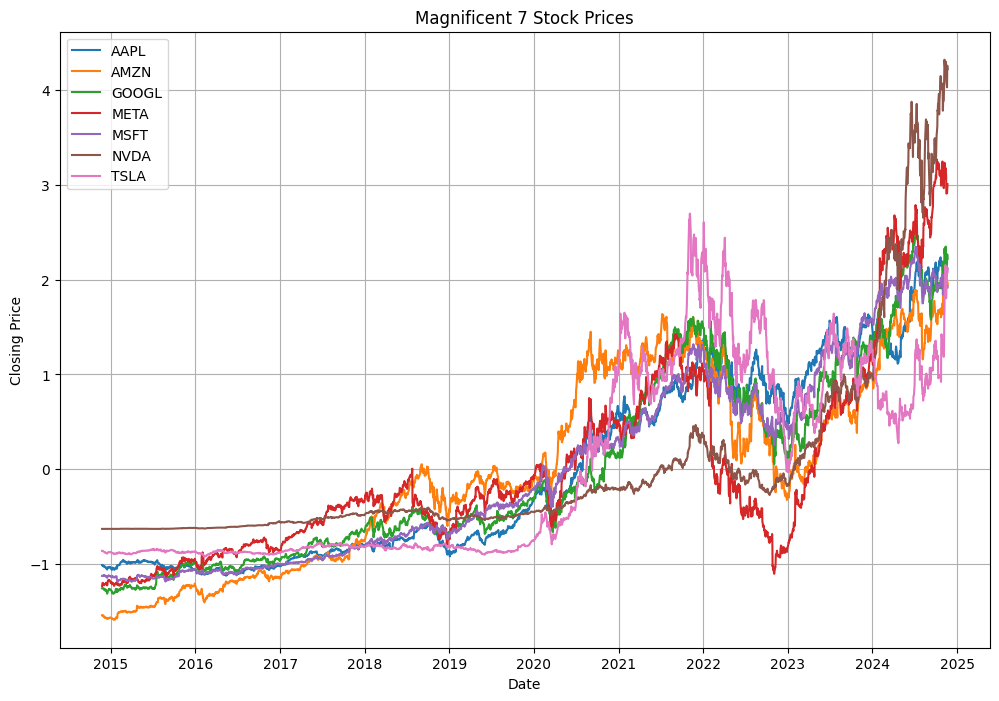

In [53]:
# Create a dictionary to store scalers for each stock
scalers = {}

# Scale each stock independently
for column in df.columns:
    scalers[column] = StandardScaler()
    df[column] = scalers[column].fit_transform(df[[column]])

plot_stock_prices(df)

In [54]:
# Define the split percentages (80% train, 10% validation, 10% test)
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Calculate split indices based on the size of the data
n = len(df)
train_index = int(n * train_size)
val_index = int(n * (train_size + val_size))

# Split the data
df_train = df[:train_index]
df_val = df[train_index:val_index]
df_test = df[val_index:]


# Convert to NumPy arrays if needed for your RNN model
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

print(f"Train Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {val_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Train Data Shape: (2012, 7)
Validation Data Shape: (251, 7)
Test Data Shape: (252, 7)


In [85]:
def train_rnn_model(df_train, df_val, df_test, sequence_length, learning_rate=0.001, epochs=100, batch_size=32, patience=20, scalers=None, l1_reg=0.001, l2_reg=0.001):
    """
    Trains a stacked LSTM model on the provided pre-split DataFrames.

    """

    # Fix random seeds
    seed_value = 42
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    # Convert DataFrames to NumPy arrays
    train_data = df_train.values
    val_data = df_val.values
    test_data = df_test.values

    # Create sequences
    def create_sequences(data, sequence_length):
        X = []
        y = []
        for i in range(len(data) - sequence_length - 1):
            X.append(data[i:i + sequence_length])
            y.append(data[i + sequence_length + 1])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_data, sequence_length)
    X_val, y_val = create_sequences(val_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], df_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], df_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], df_test.shape[1]))

    model = keras.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LeakyReLU(negative_slope=0.4))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(df_train.shape[1]))

    # Define optimizer with learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss='mse')

    # Early stopping
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, min_delta = 0.0005)

    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size,
        validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=1
    )

    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)

    # Make predictions
    predictions = model.predict(X_test)

     #Inverse transform using provided scalers
    if scalers is None:
        scalers = {}
        for i in range(7):
            scalers[i] = StandardScaler()
            scalers[i].fit(y_train[:, i].reshape(-1, 1))
            predictions[:, i] = scalers[i].inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()
            y_test[:, i] = scalers[i].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()
    else:
        pass

    train_plot_data = df_train.copy()
    val_plot_data = df_val.copy()
    test_plot_data = df_test.copy()

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)

    for i, col in enumerate(df.columns):
        train_plot_data[col] = scalers[col].inverse_transform(df_train[[col]])
        val_plot_data[col] = scalers[col].inverse_transform(df_val[[col]])
        test_plot_data[col] = scalers[col].inverse_transform(df_test[[col]])
        predictions[:, i] = scalers[col].inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()

    full_predictions = np.concatenate([np.full((sequence_length + 1, df.shape[1]), np.nan), predictions])

    # Offset predictions to align with test data
    sequence_offset = sequence_length + 1  # Sequence length + 1 for y offset
    aligned_test_index = test_plot_data.index[sequence_offset:]  # Align indices


    for i, col in enumerate(df.columns):
      plt.figure(figsize=(15, 6))
      # Plot training, validation, and test data
      plt.plot(train_plot_data.index, train_plot_data[col], label='Training Data', color='blue')
      plt.plot(val_plot_data.index, val_plot_data[col], label='Validation Data', color='orange')
      plt.plot(test_plot_data.index, test_plot_data[col], label='Test Data (Full)', color='green')
      aligned_test_index = test_plot_data.index[-predictions.shape[0]:]
      plt.plot(aligned_test_index, predictions[:, i], label='Predictions', color='red')
      plt.title(f'{col} - Actual vs. Predicted')
      plt.xlabel('Date')
      plt.ylabel('Price')
      plt.legend()
      plt.grid(True)
      plt.show()


    return {
        "model": model,
        "history": history,
        "rmse": rmse,
        "mae": mae,
        "scalers": scalers
    }

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2181 - val_loss: 0.3639 - learning_rate: 0.0010
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0574 - val_loss: 0.2735 - learning_rate: 0.0010
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0410 - val_loss: 0.2130 - learning_rate: 0.0010
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0372 - val_loss: 0.2058 - learning_rate: 0.0010
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0327 - val_loss: 0.1615 - learning_rate: 0.0010
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0300 - val_loss: 0.1397 - learning_rate: 0.0010
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0270 - val_loss: 0.1773 - learning_rate: 0.0010
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0281 - val_loss: 0.1662 - learning_rate: 0.0010
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0248 - val_loss: 0.1597 - learning_rate: 0.0010
Epoch 10/150
31/31 ━━━

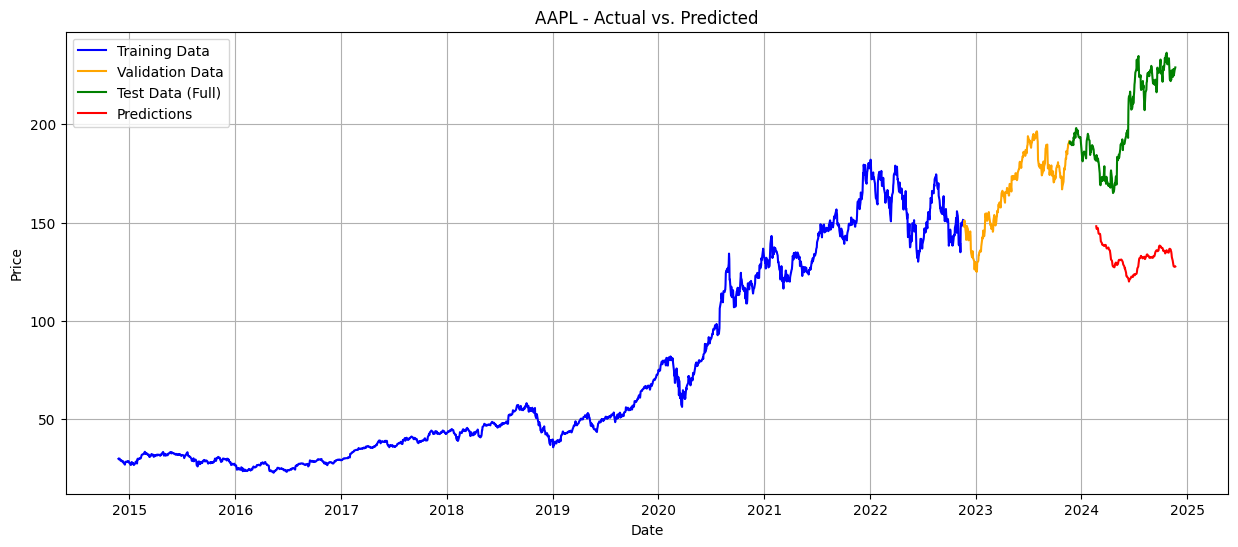

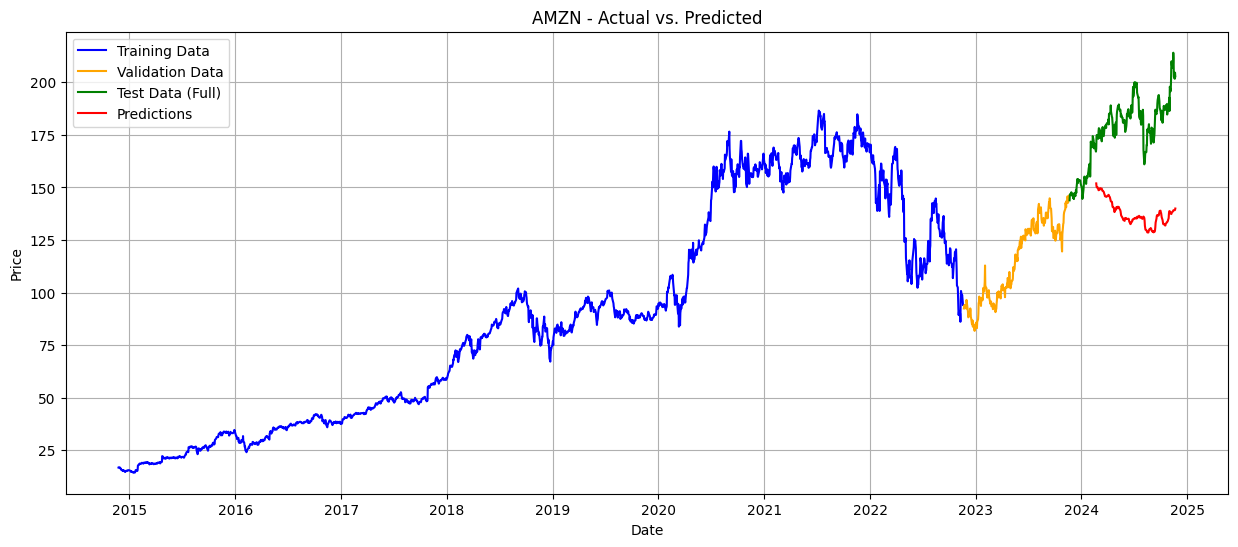

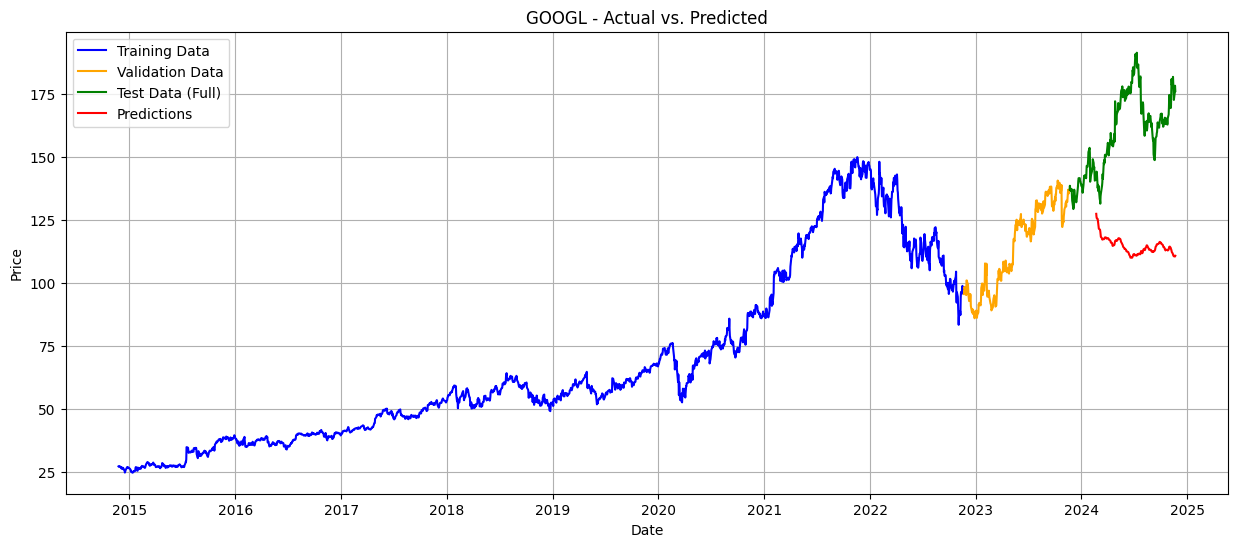

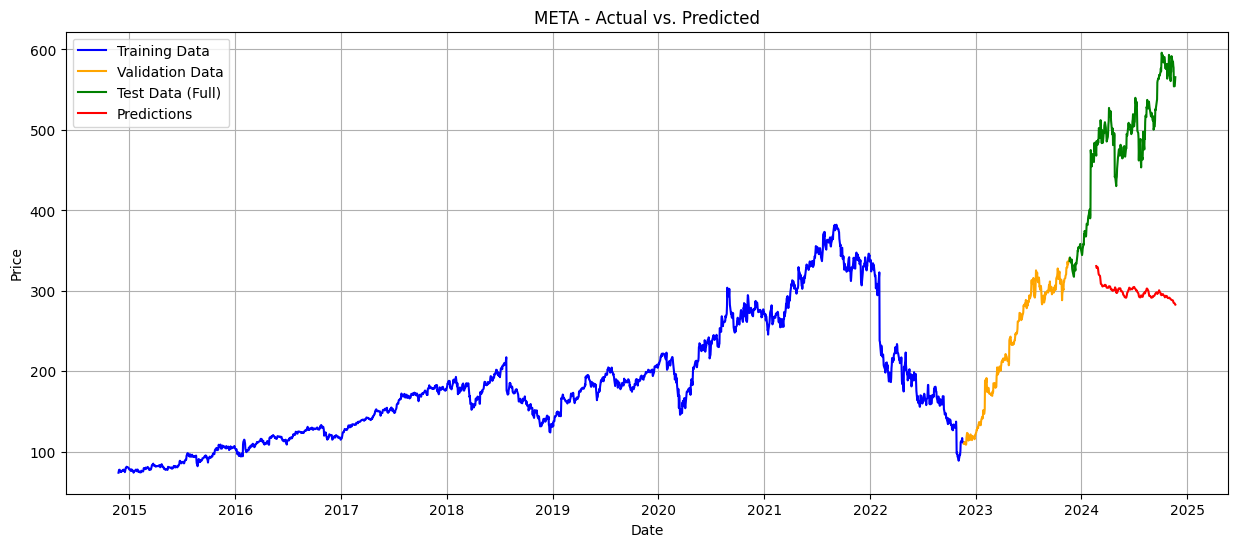

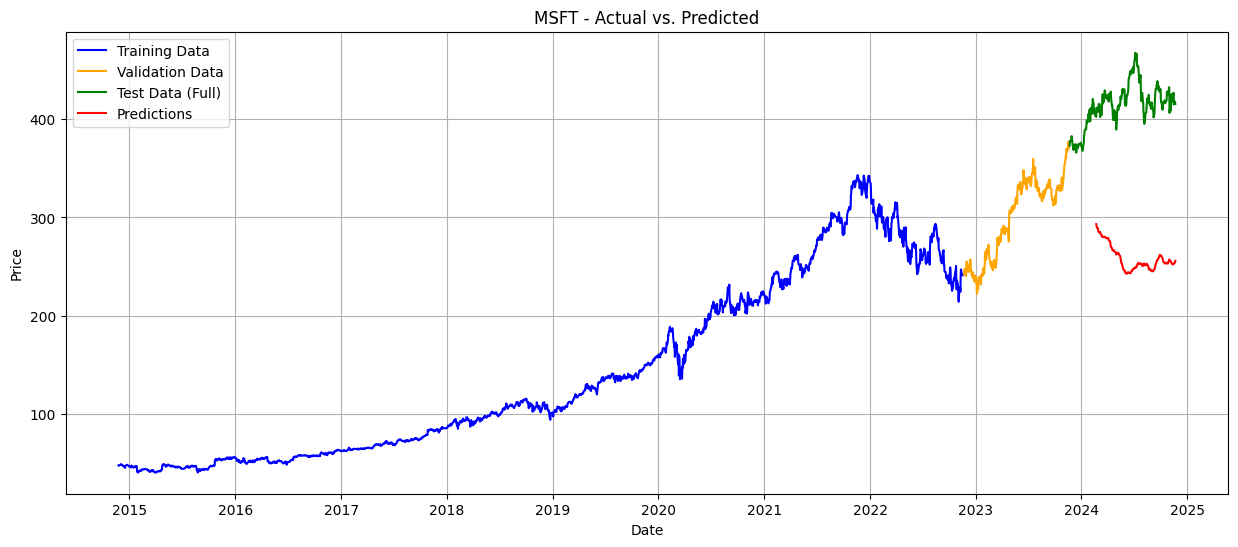

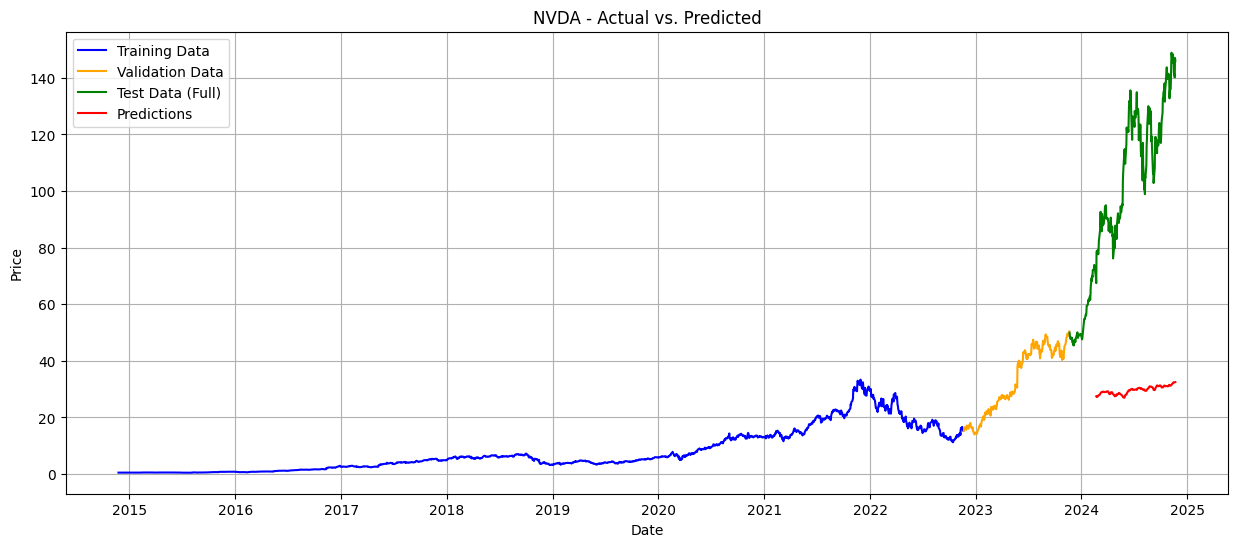

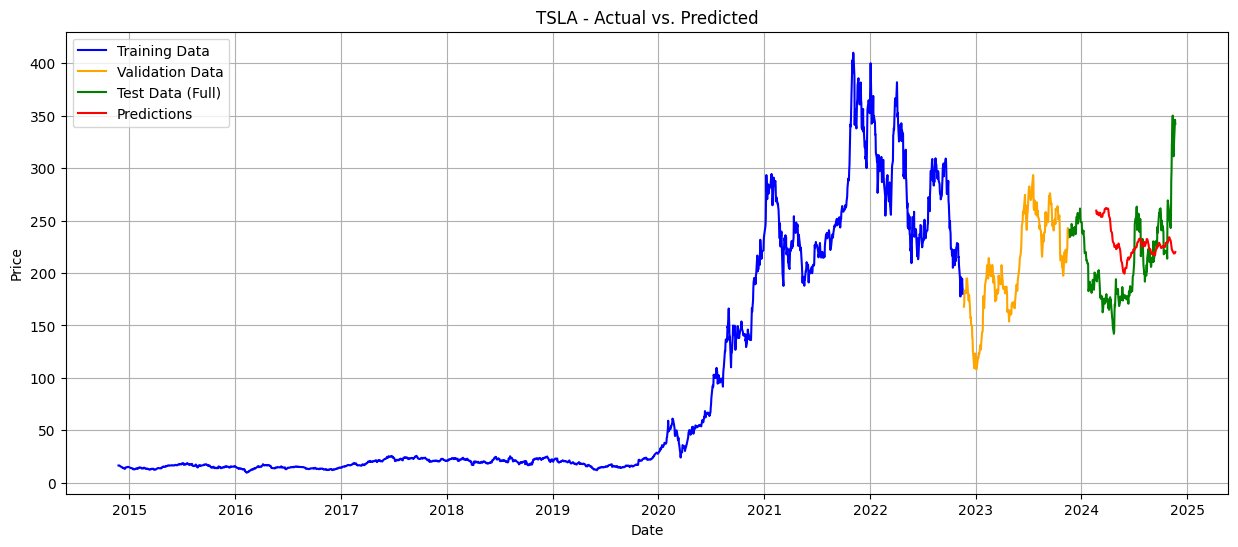

RMSE: 1.5744376414084775
MAE: 1.3566124103277661


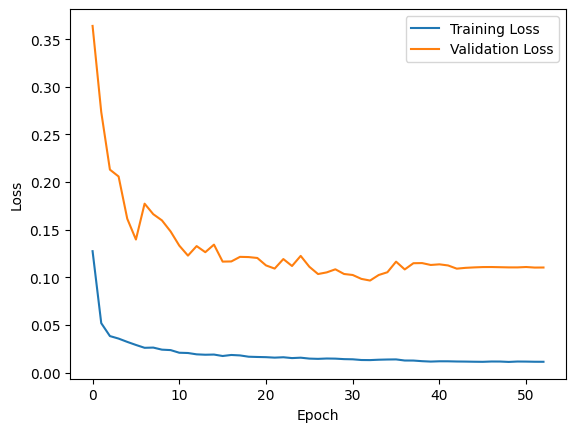

In [86]:
results = train_rnn_model(df_train.copy(), df_val.copy(), df_test.copy(),
                          sequence_length=60, batch_size=64, learning_rate=0.001, epochs=150, scalers=scalers,
                          l1_reg=0.0013, l2_reg=0.00125)
print(f"RMSE: {results['rmse']}")
print(f"MAE: {results['mae']}")

# Access the trained model and history
model = results['model']
history = results['history']
scalers = results['scalers']

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [87]:
import tensorflow as tf
import keras
from keras.layers import Layer, Input, LSTM, Dense, RepeatVector, Concatenate, TimeDistributed
from keras.models import Model
from keras import backend as K

class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1) # expand the dimension of query
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis))) # calculate the score
        attention_weights = tf.nn.softmax(score, axis=1) # softmax the score
        context_vector = attention_weights * values # multiply softmax weight with the values
        context_vector = tf.reduce_sum(context_vector, axis=1)  #sum the context vector
        return context_vector, attention_weights

    def get_config(self):
        config = super().get_config()
        return config

In [123]:
def train_rnn_model_with_attention(df_train, df_val, df_test, sequence_length, learning_rate=0.001, epochs=100, batch_size=32, patience=10, scalers=None, l1_reg=0.001, l2_reg=0.001):
    """Trains a stacked LSTM model with Bahdanau attention."""

    seed_value = 42
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    train_data = df_train.values
    val_data = df_val.values
    test_data = df_test.values

    def create_sequences(data, sequence_length):
        X = []
        y = []
        for i in range(len(data) - sequence_length - 1):
            X.append(data[i:i + sequence_length])
            y.append(data[i + sequence_length])
        return np.array(X), np.array(y)

    #Data Augmentation
    def create_sliding_windows(data, sequence_length, stride=1):
        X, y = [], []
        for i in range(0, len(data) - sequence_length, stride):
            X.append(data[i:i + sequence_length])
            y.append(data[i + sequence_length])
        return np.array(X), np.array(y)

    def smooth_timeseries(data, window_size):
    # Simple moving average smoothing
      return data.rolling(window=window_size, center=True, min_periods=1).mean()

    def directional_accuracy(y_true, y_pred):
      correct_predictions = np.sum(np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1]))
      total_predictions = len(y_true) - 1
      return correct_predictions / total_predictions

    def custom_loss(y_true, y_pred):
      mse = K.mean(K.square(y_true - y_pred))
      directional_error = K.mean(K.square(K.sign(y_true[1:] - y_true[:-1]) - K.sign(y_pred[1:] - y_pred[:-1])))
      return mse + (0.5 * directional_error)

    train_data_smoothed = smooth_timeseries(pd.DataFrame(train_data), window_size=30).values
    val_data_smoothed = smooth_timeseries(pd.DataFrame(val_data), window_size=30).values
    test_data_smoothed = smooth_timeseries(pd.DataFrame(test_data), window_size=30).values

    #Create Sliding Windows Using Smoothed Data:
    X_train, y_train = create_sliding_windows(train_data_smoothed, sequence_length, stride=7)
    X_val, y_val = create_sliding_windows(val_data_smoothed, sequence_length, stride=7)
    X_test, y_test = create_sliding_windows(test_data_smoothed, sequence_length, stride=7)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], df_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], df_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], df_test.shape[1]))

    # Define the model with attention
    encoder_inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    encoder_lstm = Bidirectional(LSTM(256, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_inputs)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])

    attention_layer = BahdanauAttention(64)
    context_vector, attention_weights = attention_layer(state_h, encoder_outputs)

    decoder_inputs = RepeatVector(sequence_length)(state_h)
    decoder_lstm = LSTM(64, return_sequences=True, return_state=True)(decoder_inputs, initial_state=[state_h, state_c])
    decoder_outputs = TimeDistributed(Dense(df_train.shape[1]))(decoder_lstm)
    model = Model(encoder_inputs, decoder_outputs)


    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss=custom_loss)

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=1)

    loss = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test)

    if scalers is None:
        scalers = {}
        for i in range(df_train.shape[1]):
            scalers[i] = StandardScaler()
            scalers[i].fit(df_train.iloc[:, i].values.reshape(-1, 1))
            predictions[:, i] = scalers[i].inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()
            y_test[:, i] = scalers[i].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()
    else:
        for i in range(df_train.shape[1]):
            predictions[:, i] = scalers[i].inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()
            y_test[:, i] = scalers[i].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)

    train_plot_data = df_train.copy()
    val_plot_data = df_val.copy()
    test_plot_data = df_test.copy()

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)

    for i, col in enumerate(df.columns):
        train_plot_data[col] = scalers[col].inverse_transform(df_train[[col]])
        val_plot_data[col] = scalers[col].inverse_transform(df_val[[col]])
        test_plot_data[col] = scalers[col].inverse_transform(df_test[[col]])
        predictions[:, i] = scalers[col].inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()

    full_predictions = np.concatenate([np.full((sequence_length + 1, df.shape[1]), np.nan), predictions])

    # Offset predictions to align with test data
    sequence_offset = sequence_length + 1  # Sequence length + 1 for y offset
    aligned_test_index = test_plot_data.index[sequence_offset:]  # Align indices

    directional_acc = directional_accuracy(y_test, predictions)
    print(f"Directional Accuracy: {directional_acc}")

    for i, col in enumerate(df.columns):
      plt.figure(figsize=(15, 6))
      # Plot training, validation, and test data
      plt.plot(train_plot_data.index, train_plot_data[col], label='Training Data', color='blue')
      plt.plot(val_plot_data.index, val_plot_data[col], label='Validation Data', color='orange')
      plt.plot(test_plot_data.index, test_plot_data[col], label='Test Data (Full)', color='green')
      aligned_test_index = test_plot_data.index[-predictions.shape[0]:]
      plt.plot(aligned_test_index, predictions[:, i], label='Predictions', color='red')
      plt.title(f'{col} - Actual vs. Predicted')
      plt.xlabel('Date')
      plt.ylabel('Price')
      plt.legend()
      plt.grid(True)
      plt.show()

    return {
        "model": model,
        "history": history,
        "rmse": rmse,
        "mae": mae,
        "scalers": scalers
    }

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.2000 - val_loss: 0.2531 - learning_rate: 0.0030
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0440 - val_loss: 0.2141 - learning_rate: 0.0030
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0342 - val_loss: 0.1651 - learning_rate: 0.0030
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0301 - val_loss: 0.2077 - learning_rate: 0.0030
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0252 - val_loss: 0.1534 - learning_rate: 0.0030
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0223 - val_loss: 0.1493 - learning_rate: 0.0030
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0210 - val_loss: 0.1646 - learning_rate: 0.0030
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0226 - val_loss: 0.1688 - learning_rate: 0.0030
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0201 - val_loss: 0.1556 - learning_rate: 0.0030
Epoch 10/150
31/31 ━━━

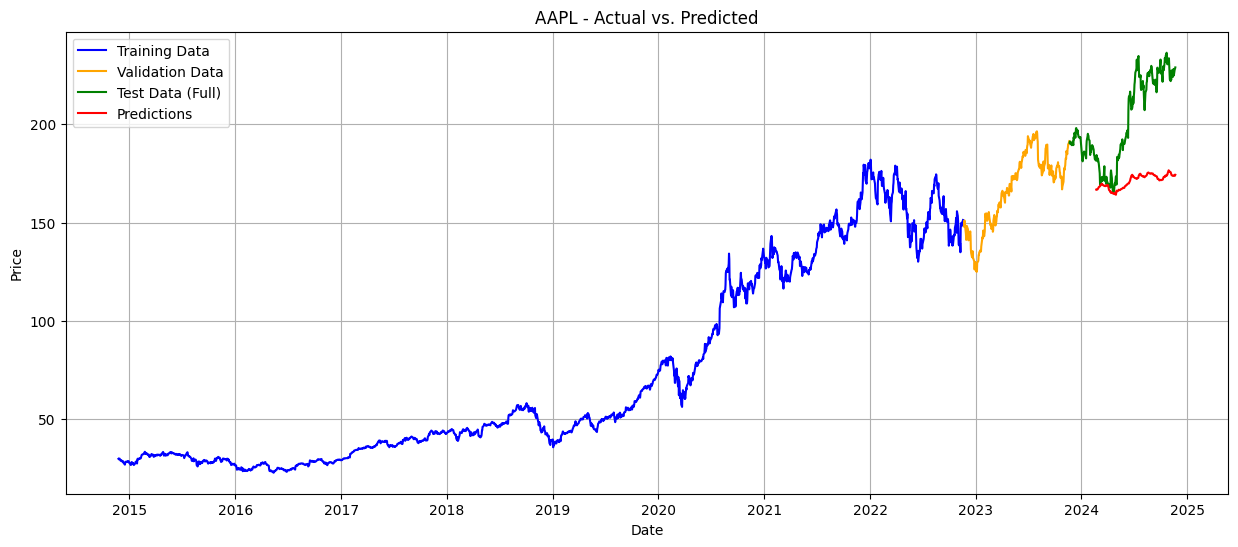

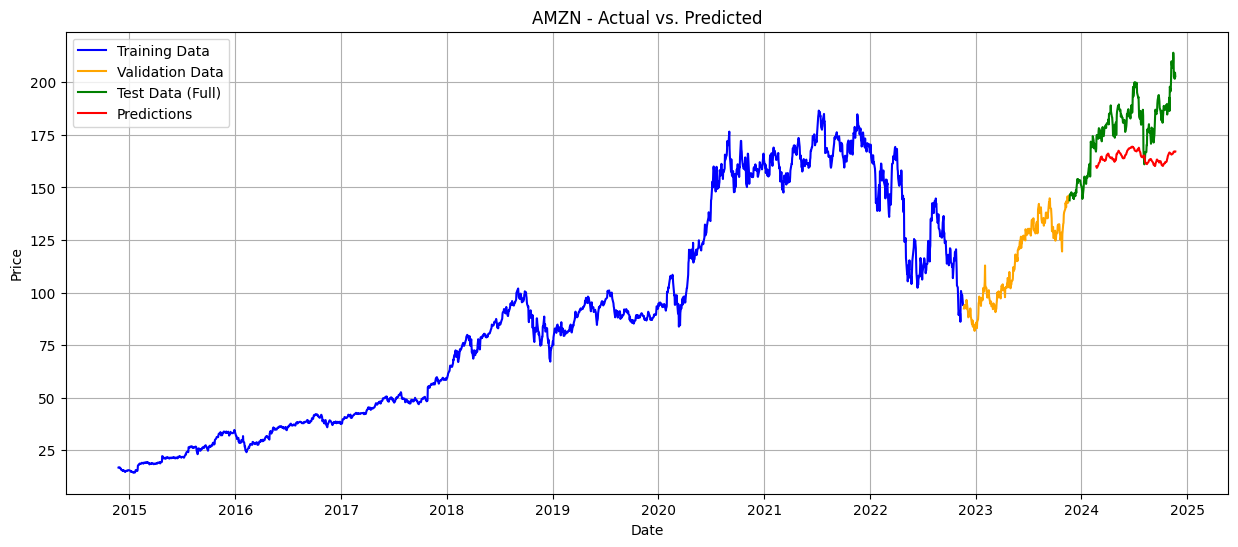

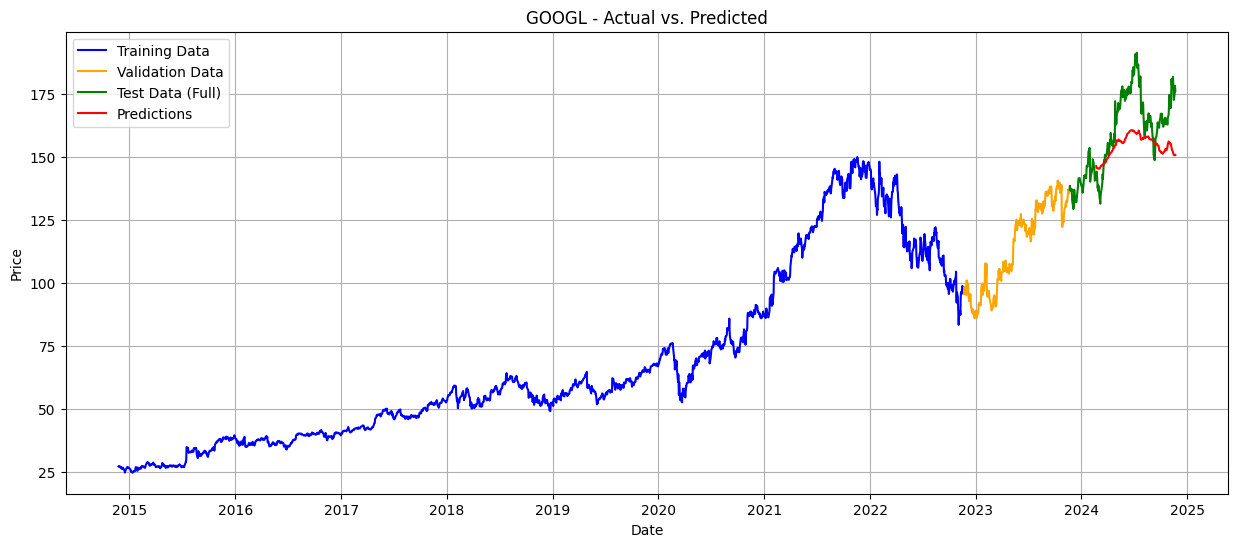

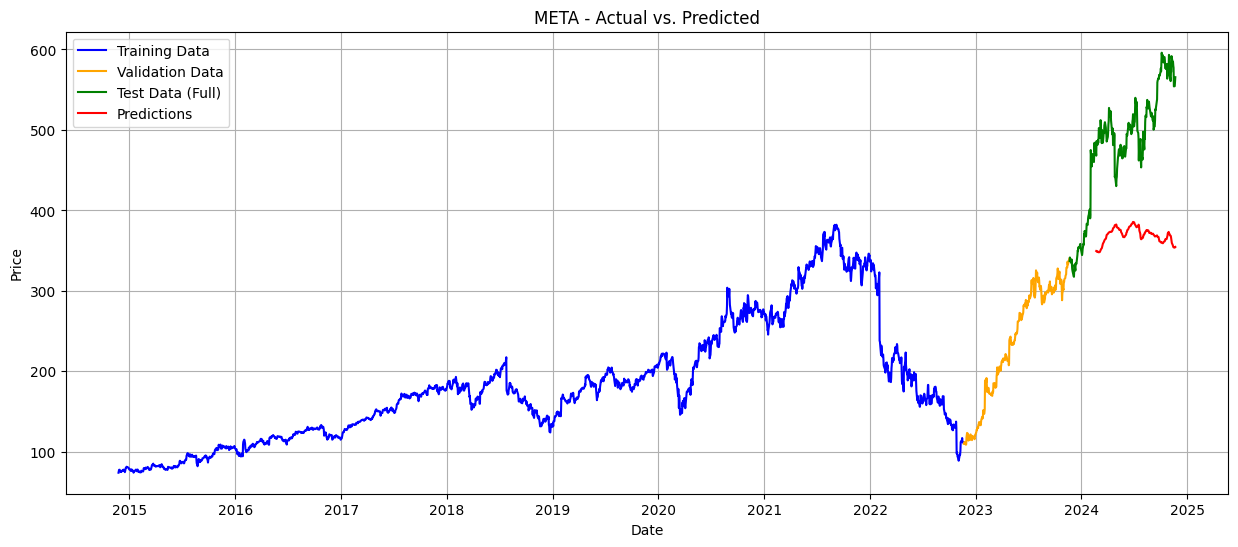

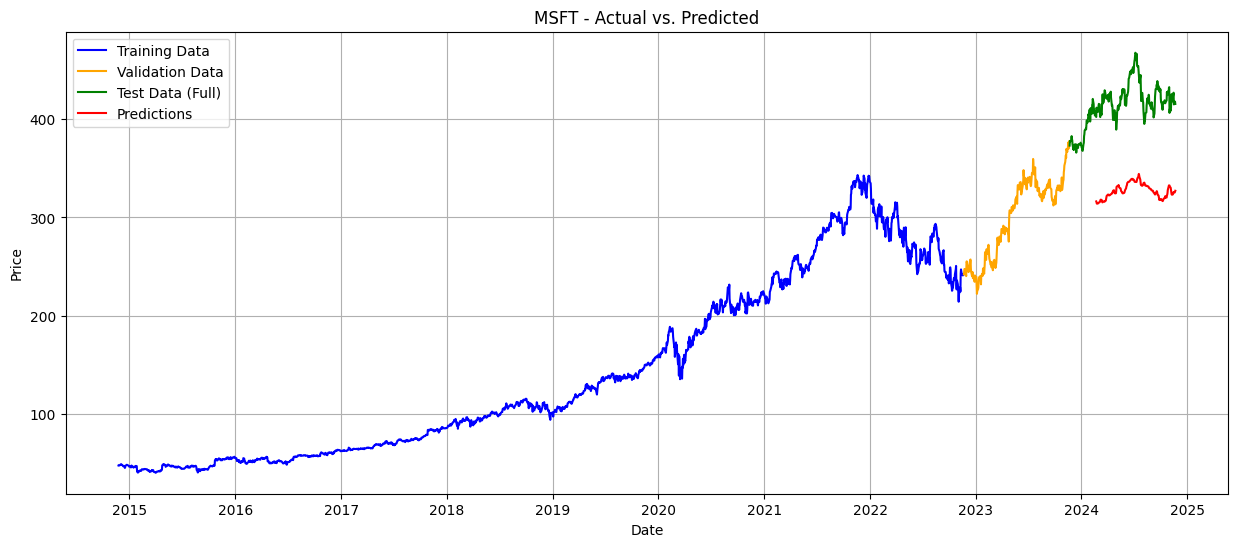

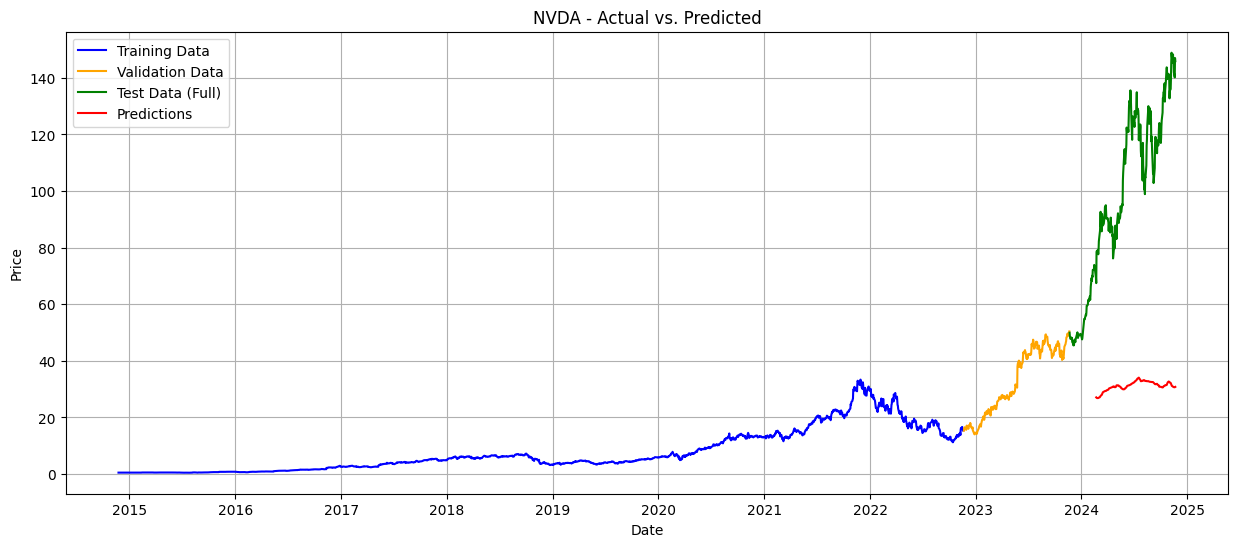

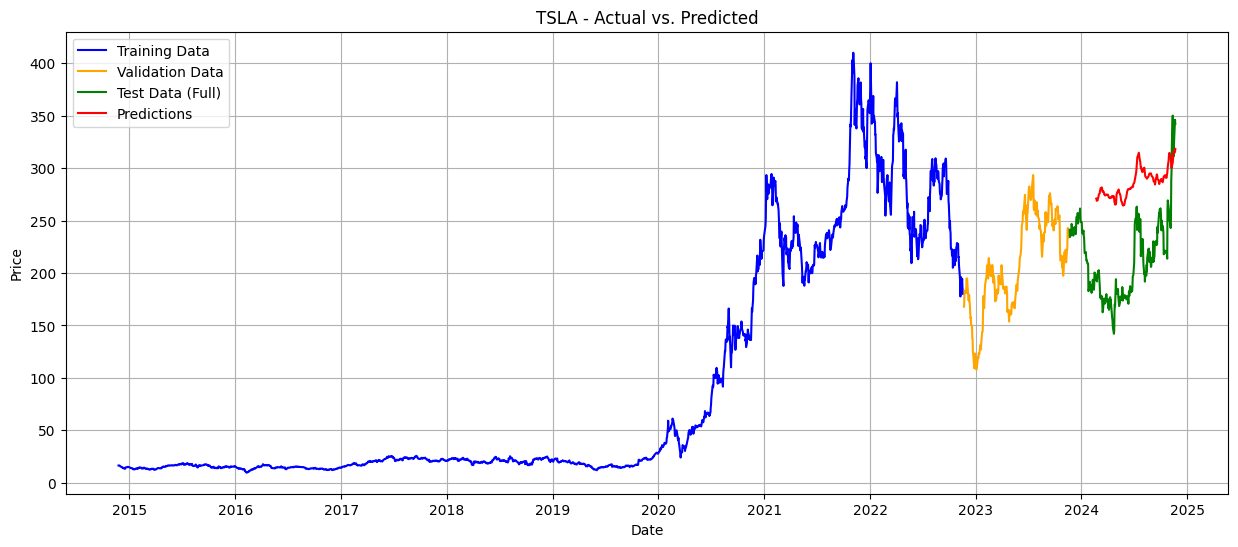

RMSE: 1.2662622705789341
MAE: 0.9456774183995919


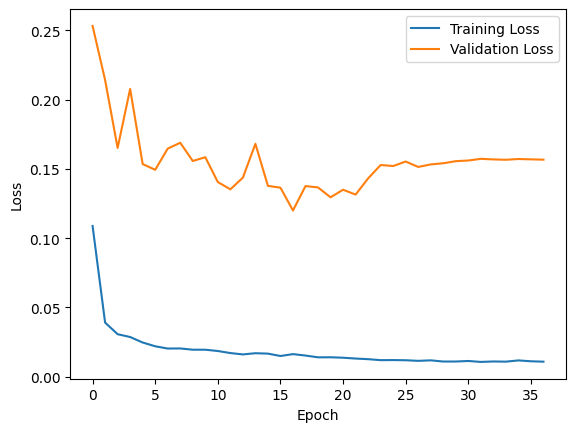

In [124]:
results = train_rnn_model(df_train.copy(), df_val.copy(), df_test.copy(),
                          sequence_length=60, batch_size=64, learning_rate=0.003, epochs=150, scalers=scalers,
                          l1_reg=0.0013, l2_reg=0.00125)
print(f"RMSE: {results['rmse']}")
print(f"MAE: {results['mae']}")

# Access the trained model and history
model = results['model']
history = results['history']
scalers = results['scalers']

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()